# Social Network Analysis on Stackoverflow

In [1]:
import re
import ast
import pandas as pd
import networkx as nx
import more_itertools
import matplotlib.pyplot as plt
import scipy as sp
import collections
import seaborn as sns
import requests
import math
from wordcloud import WordCloud
from difflib import SequenceMatcher
from collections import Counter
from scipy import stats

## Exploring & Preprocessing

In [2]:
# get questions - tags data

tags_data = pd.read_csv("../../PycharmProjects/StackoverflowSNA/questions.csv")
tags_data.head()

,QuestionID,IsAnswered,UserID,Tags
0,59538132,True,1175327,"['asp.net-core', 'iis', 'identityserver4', 'bl..."
1,59538127,True,11217383,"['android', 'android-constraintlayout']"
2,59538126,True,12628540,"['excel', 'excel-formula', 'sum']"
3,59538123,True,12488144,"['php', 'html', 'wordpress', 'dom', 'xpath']"
4,59538122,False,10946509,"['html', 'twitter-bootstrap', 'bootstrap-4']"


In [3]:
tags_data["Tags"].isnull().sum()

0

In [4]:
tags_data.isnull().values.any()

False

In [5]:
tags_data.shape

(1799655, 4)

In [6]:
# get value counts

tags_data_is_answered = tags_data.apply(pd.value_counts)

In [7]:
tags_data_is_answered.head(2)

,QuestionID,IsAnswered,UserID,Tags
False,NaN,743652.0,28082.0,NaN
True,NaN,1056003.0,NaN,NaN


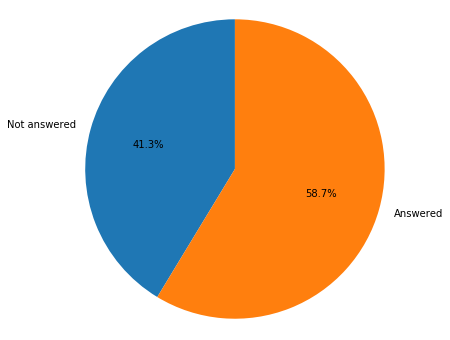

In [9]:
vals = [743652, 1056003]
cats = ["Not answered", "Answered"]

fig1, ax1 = plt.subplots(figsize=(6, 6))
ax1.pie(vals, labels=cats, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.show()

In [10]:
# get tag count (frequency)

tag_count = dict()

def get_tag_count(row):
    global tag_count
    tags_str = row["Tags"]
    tags = ast.literal_eval(tags_str)
    for tag in tags:
        if not tag in tag_count:
            tag_count[tag] = 1
        else:
            tag_count[tag] = tag_count[tag] + 1


tags_data.apply(get_tag_count, axis=1)

0          None
1          None
2          None
3          None
4          None
           ... 
1799650    None
1799651    None
1799652    None
1799653    None
1799654    None
Length: 1799655, dtype: object

In [11]:
# sort and get first 20 tag frequency

tag_count_sorted = {k: v for k, v in sorted(tag_count.items(), key=lambda item: item[1], reverse=True)}
tag_count_sorted = more_itertools.take(20, tag_count_sorted.items())
tag_count_sorted

[('python', 227667),
 ('javascript', 191299),
 ('java', 128706),
 ('c#', 100970),
 ('android', 86712),
 ('php', 79970),
 ('html', 77747),
 ('python-3.x', 62110),
 ('reactjs', 60049),
 ('angular', 50964),
 ('r', 50713),
 ('css', 50650),
 ('c++', 50190),
 ('sql', 49787),
 ('node.js', 49145),
 ('pandas', 39184),
 ('mysql', 39161),
 ('jquery', 38736),
 ('swift', 35041),
 ('ios', 33325)]

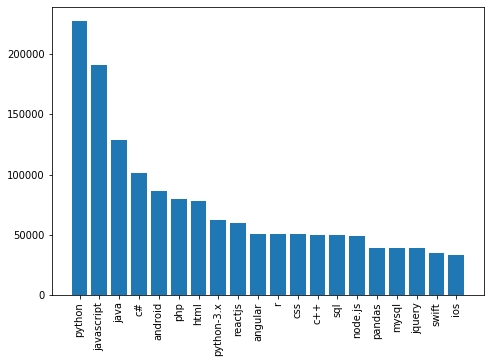

In [12]:
# plot the tag frequency

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
langs = [i[0] for i in tag_count_sorted]
vals = [i[1] for i in tag_count_sorted]
ax.bar(langs,vals)
plt.xticks(rotation='vertical')
plt.show()

In [13]:
# get tag count of unanswered questions (frequency)

tag_count = dict()

def get_tag_count(row):
    global tag_count
    is_answered = row["IsAnswered"]
    if is_answered == False:
        tags_str = row["Tags"]
        tags = ast.literal_eval(tags_str)
        for tag in tags:
            if not tag in tag_count:
                tag_count[tag] = 1
            else:
                tag_count[tag] = tag_count[tag] + 1


tags_data.apply(get_tag_count, axis=1)

0          None
1          None
2          None
3          None
4          None
           ... 
1799650    None
1799651    None
1799652    None
1799653    None
1799654    None
Length: 1799655, dtype: object

In [14]:
# sort and get first 20 tag frequency of unanswered questions

tag_count_sorted = {k: v for k, v in sorted(tag_count.items(), key=lambda item: item[1], reverse=True)}
tag_count_sorted = more_itertools.take(20, tag_count_sorted.items())
tag_count_sorted

[('python', 83865),
 ('javascript', 73630),
 ('java', 56826),
 ('android', 43799),
 ('c#', 42250),
 ('php', 37375),
 ('html', 31029),
 ('reactjs', 23491),
 ('python-3.x', 23490),
 ('node.js', 22219),
 ('angular', 20958),
 ('css', 19227),
 ('r', 17776),
 ('mysql', 16866),
 ('c++', 16319),
 ('jquery', 16199),
 ('sql', 15653),
 ('ios', 15176),
 ('swift', 13811),
 ('django', 12666)]

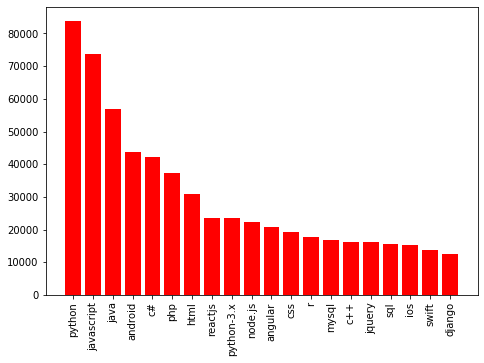

In [15]:
# plot the tag frequency

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
langs = [i[0] for i in tag_count_sorted]
vals = [i[1] for i in tag_count_sorted]
ax.bar(langs, vals, color="red")
plt.xticks(rotation='vertical')
plt.show()

In [16]:
# get user frequency

user_id_occurance = tags_data["UserID"].value_counts().iloc[1:11]
user_id_occurance

8291684     265
1103606     246
6813231     246
1422604     237
10823490    233
4607841     230
7954280     228
5783745     222
3317808     216
577805      206
Name: UserID, dtype: int64

In [17]:
# show the total number of questions asked by the most asking users and tags

user_ids = list(user_id_occurance.index)
tags_data[tags_data["UserID"].isin(user_ids)]

,QuestionID,IsAnswered,UserID,Tags
1381,59534418,False,577805,"['asp.net-core', 'asp.net-core-3.0', 'asp.net-..."
1534,59534021,True,577805,"['npm', 'webpack']"
3133,59529452,True,8291684,"['angular', 'angular8']"
7901,59516017,True,3317808,"['amazon-web-services', 'amazon-ec2', 'amazon-..."
8175,59515266,True,3317808,"['amazon-web-services', 'amazon-ec2', 'amazon-..."
...,...,...,...,...
1794577,54008558,True,7954280,"['sql', 'db2']"
1797224,54000157,True,3317808,"['docker', 'dockerfile']"
1797556,53999063,False,10823490,"['javascript', 'asp.net']"
1798112,53997214,True,10823490,"['asp.net', 'webforms']"


In [18]:
# get all tags

tags_set = set()

def get_tags(row):
    global tags_set, count
    tags_str = row["Tags"]
    tags = set(ast.literal_eval(tags_str))
    tags_set = tags_set | tags
    
tags_data.apply(get_tags, axis=1)

0          None
1          None
2          None
3          None
4          None
           ... 
1799650    None
1799651    None
1799652    None
1799653    None
1799654    None
Length: 1799655, dtype: object

In [19]:
tags_list = list(tags_set)
len(tags_list)

41536

In [20]:
# remove similar tags

"""
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()


for tag_a in tags_list:
    tags_list_tmp = [x for x in tags_list if x != tag_a]
    for tag_b in tags_list_tmp:
        sim = similar(tag_a, tag_b)
        if sim > 0.9:
            print(tag_a, tag_b)
"""

# This method generates lots of similar things like dagger - dragger, which is similar but not same thing
# I decided to remove tags that are same things but different versions like asp.net-4.5 - asp.net-3.5
# Not the best but better than nothing =)

tags_with_versions = [tag for tag in tags_list if re.search("[a-zA-Z]-[0-9]", tag)]
print(len(tags_with_versions))

def strip_version(tag):
    return "-".join(tag.split("-")[:-1])

strip_version("asp.net-4.5")

# I will use this method in creating graph section later...

1185


'asp.net'

In [21]:
# get question - respondents data

answers_data = pd.read_csv("../../PycharmProjects/StackoverflowSNA/answers.csv")
answers_data.head()

,QuestionID,AnsweredUserIDs
0,59538081,[2557682]
1,59538110,"[485674, 485674, 12626835]"
2,59538126,"[12125181, 10671926, 4851590]"
3,59538132,[5463242]
4,59538068,"[10808802, 3234890]"


In [22]:
answers_data.isnull().values.any()

False

In [23]:
answers_data.tail()

,QuestionID,AnsweredUserIDs
1036951,53992258,[10825793]
1036952,53992300,"[5862071, 6815131]"
1036953,53992233,[139985]
1036954,53992252,[1144035]
1036955,53992234,[4932316]


In [24]:
# merge questions - tags data & questions - respondents data

user_answered_users_data = tags_data.merge(answers_data, on="QuestionID")[["UserID", "AnsweredUserIDs"]]
user_answered_users_data.head()

,UserID,AnsweredUserIDs
0,1175327,[5463242]
1,11217383,[10885621]
2,12628540,"[12125181, 10671926, 4851590]"
3,12488144,[965834]
4,5676949,[9357872]


In [25]:
# get respondent frequency

answered_users_count = dict()

def get_answered_users_count(row):
    global answered_users_count
    answered_user_ids_str = row["AnsweredUserIDs"]
    answered_user_ids = ast.literal_eval(answered_user_ids_str)
    for user_id in answered_user_ids:
        if not user_id in answered_users_count:
            answered_users_count[user_id] = 1
        else:
            answered_users_count[user_id] = answered_users_count[user_id] + 1

    
user_answered_users_data.apply(get_answered_users_count, axis=1)

0          None
1          None
2          None
3          None
4          None
           ... 
1036951    None
1036952    None
1036953    None
1036954    None
1036955    None
Length: 1036956, dtype: object

In [26]:
# sort & show frequencies of top 20

answered_users_sorted = {k: v for k, v in sorted(answered_users_count.items(), key=lambda item: item[1], reverse=True)}
answered_users_sorted = more_itertools.take(20, answered_users_sorted.items())
del answered_users_sorted[1]
answered_users_sorted

[(1144035, 9515),
 (2901002, 4934),
 (3732271, 4258),
 (1863229, 3059),
 (3962914, 3054),
 (7964527, 2607),
 (10498828, 2558),
 (10676716, 2348),
 (1447675, 2320),
 (1491895, 2311),
 (9515207, 2109),
 (3832970, 1892),
 (67579, 1783),
 (5632629, 1774),
 (209103, 1746),
 (807126, 1701),
 (9473764, 1668),
 (10221765, 1555),
 (157247, 1490)]

In [27]:
# get user - tags data

users_tags_data = pd.read_csv("../../PycharmProjects/StackoverflowSNA/user_tags.csv")
users_tags_data.head()

,UserID,Tags
0,2557682,"['asp.net-core', 'c#']"
1,1175327,"['c#', 'php', 'angularjs', 'javascript', 'rege..."
2,506147,"['c#', 'sql-server', '.net', 'asp.net-core', '..."
3,5676949,"['javascript', 'css', 'reactjs', 'html', 'ruby..."
4,10946509,"['django', 'html', 'css']"


In [28]:
users_tags_data.isnull().values.any()

False

In [29]:
users_tags_data.shape

(130338, 2)

## Creating graphs

(Data are collected from Exchange API and related csv files are created at different project)

In [30]:
# creating the first graph: tags network
# used strip_version method that defined in preprocess section

def add_vals_to_graph(row):
    tags_str = row["Tags"]
    tags = ast.literal_eval(tags_str)
    tags = [strip_version(tag) if re.search("[a-zA-Z]-[0-9]", tag) else tag for tag in tags]
    
    G.add_nodes_from(tags)
    
    for i, tag in enumerate(tags):
        for j in range(i + 1, len(tags)):
            if G.has_edge(tags[i], tags[j]):
                G[tags[i]][tags[j]]["weight"] += 1
            else:
                G.add_edge(tags[i], tags[j], weight=1)
            

G = nx.Graph()
tags_data.apply(add_vals_to_graph, axis=1)

0          None
1          None
2          None
3          None
4          None
           ... 
1799650    None
1799651    None
1799652    None
1799653    None
1799654    None
Length: 1799655, dtype: object

In [31]:
# write network to gexf file to reopen in gephi to visualize data

nx.write_gexf(G, "../Data/sna-stackoverflow/questions_tags.gexf")

In [32]:
# create second graph: users help network (question owner <- answered user)

def add_vals_to_di_users_graph(row):
    user_id = row["UserID"]
    users_answered_str = row["AnsweredUserIDs"]
    users_answered = ast.literal_eval(users_answered_str)
    
    G_users.add_node(user_id)
    
    for user_id_answered in users_answered:
        G_users.add_node(user_id_answered)
        G_users.add_edge(user_id_answered, user_id)


G_users = nx.DiGraph()
user_answered_users_data.apply(add_vals_to_di_users_graph, axis=1)

0          None
1          None
2          None
3          None
4          None
           ... 
1036951    None
1036952    None
1036953    None
1036954    None
1036955    None
Length: 1036956, dtype: object

In [33]:
# write network to gexf file to reopen in gephi to visualize data

nx.write_gexf(G_users, "../Data/sna-stackoverflow/users.gexf")

In [34]:
# create third graph: users - tags networks

def add_vals_to_users_tags_graph(row):
    user_id = row["UserID"]
    tags_str = row["Tags"]
    tags = ast.literal_eval(tags_str)
    
    G_users_tags.add_node(user_id, type="user")
    
    for tag in tags:
        G_users_tags.add_node(tag, type="tag")
        G_users_tags.add_edge(user_id, tag)


G_users_tags = nx.Graph()
users_tags_data.apply(add_vals_to_users_tags_graph, axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
130333    None
130334    None
130335    None
130336    None
130337    None
Length: 130338, dtype: object

In [35]:
# write network to gexf file to reopen in gephi to visualize data

nx.write_gexf(G_users_tags, "../Data/sna-stackoverflow/users_tags.gexf")

## Analysis

### Tags network

<img src="SNASO/tags_to_tags.png" style="height:500px" />

In [36]:
tags_graph = G

In [37]:
print(nx.info(tags_graph))

Name: 
Type: Graph
Number of nodes: 40491
Number of edges: 988740
Average degree:  48.8375


In [38]:
print("Density of graph:", nx.density(tags_graph))

Density of graph: 0.0012061624956474781


In [39]:
print("Clustering coefficent:", nx.average_clustering(tags_graph))

Clustering coefficent: 0.634758010728


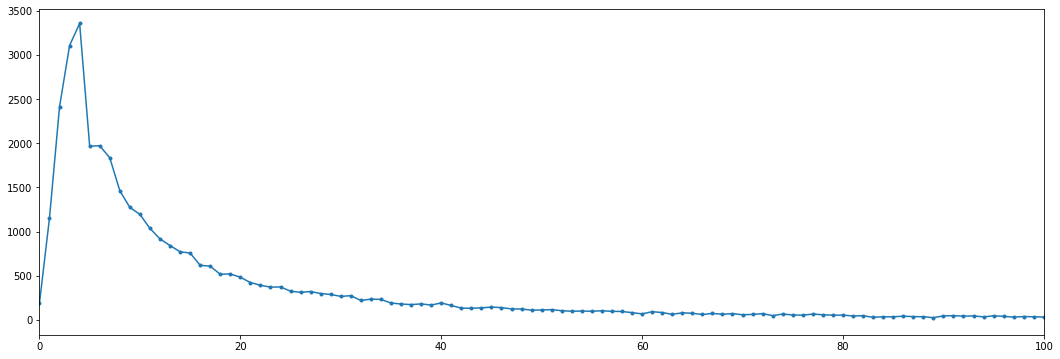

In [40]:
# plot degree distribution

hist = nx.degree_histogram(tags_graph)
plt.figure(figsize=(18, 6))
plt.plot(hist, marker='.')
plt.xlim((0, 100))
plt.show()

In [41]:
degrees = tags_graph.degree() 
deg_values = [val[1] for val in degrees]
degrees_h = Counter(deg_values)
degrees_dict = collections.OrderedDict(sorted(degrees_h.items()))
degrees_hist = list(degrees_dict.values())
degrees_values = list(degrees_dict.keys())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  app.launch_new_instance()


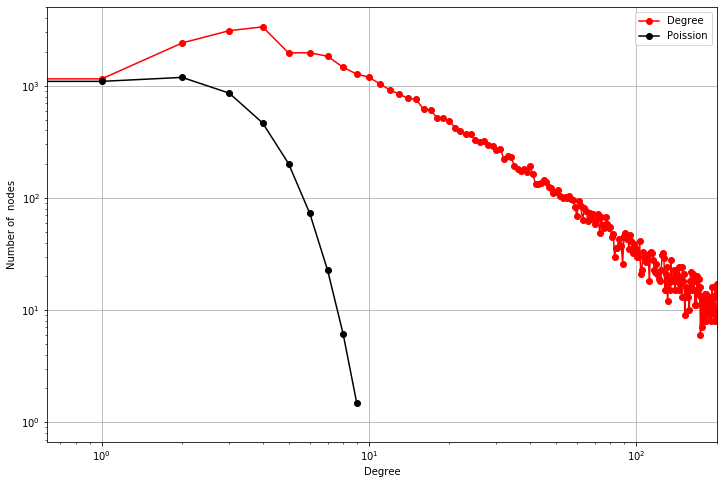

In [42]:
# plot degree distribution in log-log

mu = 2.17
sigma = sp.sqrt(mu)
mu_plus_sigma = mu + sigma
x = range(0, 10)
prob = stats.poisson.pmf(x, mu) * 4426

plt.figure(figsize=(12, 8)) 
plt.grid(True)
plt.loglog(degrees_values, degrees_hist, 'ro-')
plt.plot(x, prob, "o-", color="black")
plt.legend(['Degree','Poission'])
plt.xlabel('Degree')
plt.ylabel('Number of  nodes')
plt.xlim([0, 2 * 10 ** 2])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


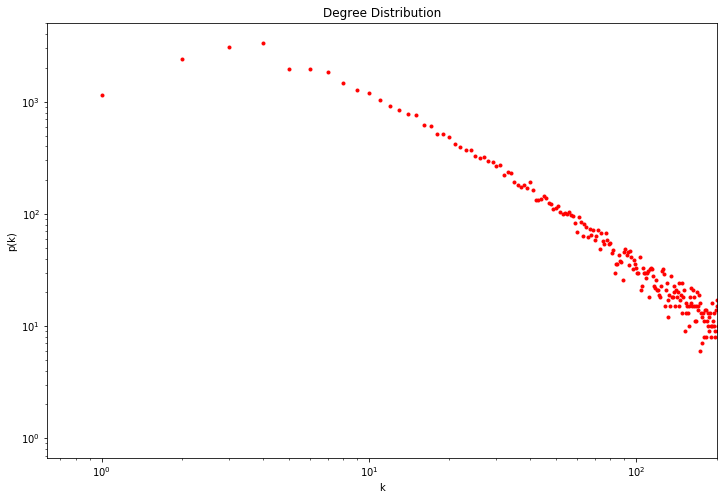

In [43]:
degrees =dict(tags_graph.degree())
values = sorted(set(degrees.values()))
hist = [list(degrees.values()).count(x) for x in values]

plt.figure(figsize=(12, 8)) 
plt.loglog(values, hist, 'r.') 
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Degree Distribution')
plt.xlim([0, 2*100**1])
plt.show()

In [44]:
# some shortest paths between irrelevant tags

nx.shortest_path(tags_graph, source="react-native-image", target="nats-streaming-server")

['react-native-image', 'react-native', 'node.js', 'nats-streaming-server']

In [45]:
nx.shortest_path(tags_graph, source="udp", target="jwt")

['udp', 'javascript', 'jwt']

In [46]:
nx.shortest_path(tags_graph, source="mongoose", target="linear-algebra")

['mongoose', 'python', 'linear-algebra']

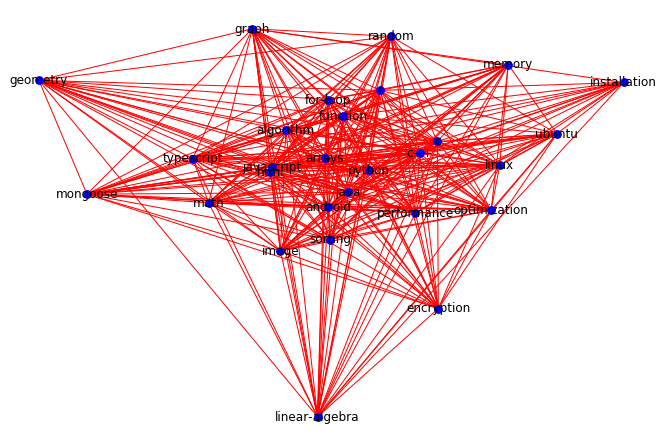

In [47]:
# simple sub graph consists paths that pass through mongoose and linear-algebra tags

paths = nx.all_shortest_paths(tags_graph, source="mongoose", target="linear-algebra")
paths = [i for i in paths]

h = nx.subgraph(tags_graph, sum([i for i in paths], []))   

pos = nx.spring_layout(h)
plt.figure(figsize=(9, 6))
nx.draw(h, pos=pos, node_color='b', edge_color='r', node_size=60, with_labels=True)
plt.show()

In [48]:
# generate & plot tags word cloud

word_cloud = WordCloud(width=2000, height=2000, background_color="black", colormap="Set2", 
                                collocations=False).generate_from_frequencies(dict(nx.degree(tags_graph)))

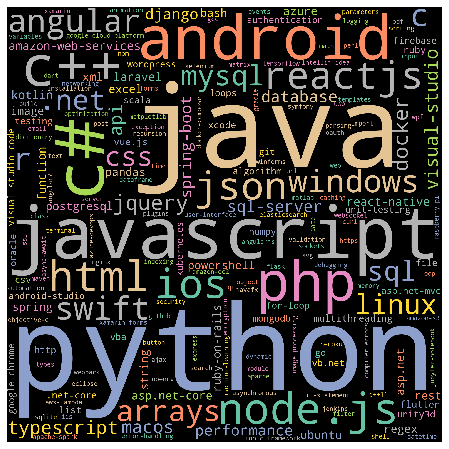

In [49]:
plt.figure(figsize=(8, 8))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [50]:
nx.is_connected(tags_graph)

False

In [51]:
# graph is not connected, get components

components = nx.connected_components(tags_graph)
components = list(components)
len(components)

200

In [52]:
# components that are not connected to main part

components[1:]

[{'map-basic'},
 {'cachegrind'},
 {'veeva', 'vql'},
 {'livecode'},
 {'manatee.trello'},
 {'lansa'},
 {'deepstream.io'},
 {'watson-studio-desktop'},
 {'torquebox'},
 {'paymill'},
 {'daemontools'},
 {'shareandcharge'},
 {'cobbler'},
 {'kronos-workforce-central', 'kronos-workforce-ready-suite'},
 {'ccc'},
 {'linux-smack'},
 {'chef-habitat'},
 {'josso'},
 {'vulas'},
 {'projekktor'},
 {'neutralinojs'},
 {'shex'},
 {'rightfax'},
 {'vlfeat'},
 {'amplience-dynamic-content'},
 {'madge'},
 {'pa11y'},
 {'eazfuscator'},
 {'pyiron'},
 {'kabanero'},
 {'traccar'},
 {'objectgears'},
 {'origen-sdk'},
 {'maxwell'},
 {'grunt-contrib-connect'},
 {'pymesh'},
 {'ruby-install'},
 {'newlisp'},
 {'macaulay2'},
 {'de4dot'},
 {'mkusertrackingmode'},
 {'flyte'},
 {'fogbugz', 'fogbugz-api'},
 {'espocrm'},
 {'kademi'},
 {'enterprisedt'},
 {'content-tools'},
 {'xmodem'},
 {'bosun'},
 {'statistica'},
 {'sigmaplot'},
 {'aws-lake-formation'},
 {'c-minus-minus'},
 {'jqchart'},
 {'appsody'},
 {'wake'},
 {'inform7'},
 {'a

In [53]:
# get largest connected component

largest_connected_component = tags_graph.subgraph(components[0])

In [54]:
# Filter the graph for next operations

tags_node_degs = nx.degree(tags_graph)
filtered_tags_graph = nx.subgraph(tags_graph, [x for x in tags_graph.nodes() if tags_node_degs[x] > 1000])
print(nx.info(filtered_tags_graph))

Name: 
Type: Graph
Number of nodes: 208
Number of edges: 17123
Average degree: 164.6442


In [55]:
print("diameter:", nx.diameter(filtered_tags_graph))

diameter: 2


In [56]:
print("shortest path length:", nx.average_shortest_path_length(filtered_tags_graph))

shortest path length: 1.206893348197696


In [57]:
print("node connectivity", nx.node_connectivity(filtered_tags_graph))

node connectivity 99


In [58]:
# degree centrality

nodes_deg_cen = nx.degree_centrality(tags_graph)
nodes_deg_cen_sorted = dict(sorted(nodes_deg_cen.items(), key=lambda item: item[1], reverse=True))

In [59]:
deg_cent_df = pd.DataFrame()    
deg_cent_df['name'] = [val[0] for val in list(nodes_deg_cen_sorted.items())[:10]]
deg_cent_df['centrality'] = [val[1] for val in list(nodes_deg_cen_sorted.items())[:10]]
deg_cent_df

,name,centrality
0,python,0.307755
1,java,0.283947
2,javascript,0.263571
3,c#,0.237540
4,android,0.181971
5,c++,0.157471
6,php,0.151420
7,node.js,0.138627
8,html,0.133366
9,ios,0.122524


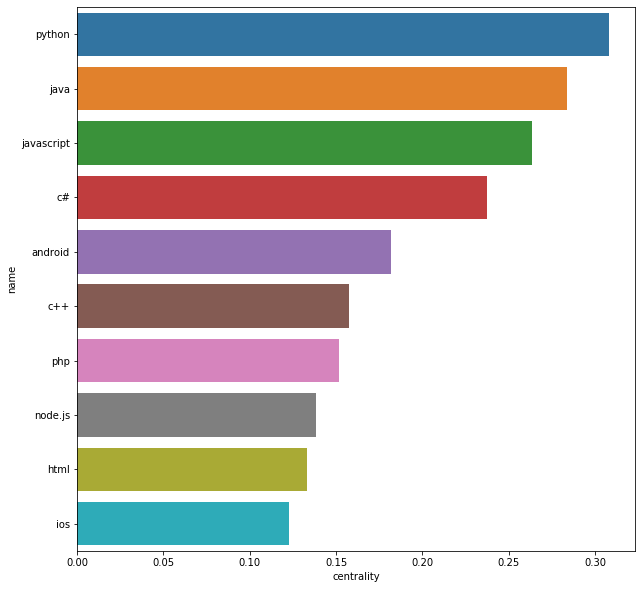

In [60]:
plt.figure(figsize=(10, 10))
_ = sns.barplot(x="centrality", y="name", data=deg_cent_df, orient='h')
plt.show()

In [61]:
# betweennes centrality

nodes_bet_cen = nx.betweenness_centrality(filtered_tags_graph)
nodes_bet_cen_sorted = dict(sorted(nodes_bet_cen.items(), key=lambda item: item[1], reverse=True))

In [62]:
bet_cent_df = pd.DataFrame()    
bet_cent_df['name'] = [val[0] for val in list(nodes_bet_cen_sorted.items())[:10]]
bet_cent_df['centrality'] = [val[1] for val in list(nodes_bet_cen_sorted.items())[:10]]
bet_cent_df

,name,centrality
0,python,0.001904
1,java,0.001895
2,json,0.001889
3,file,0.001888
4,c#,0.001874
5,javascript,0.001842
6,windows,0.001808
7,android,0.001797
8,performance,0.001786
9,node.js,0.001751


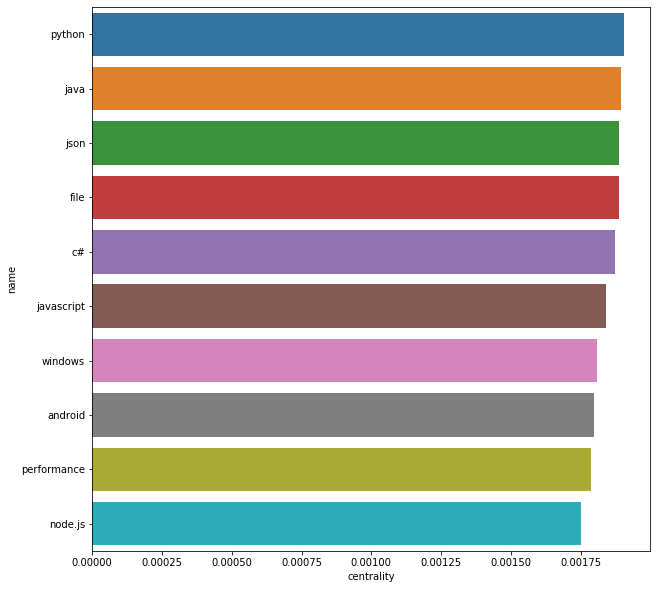

In [63]:
plt.figure(figsize=(10, 10))
_ = sns.barplot(x="centrality", y="name", data=bet_cent_df, orient='h')
plt.show()

In [64]:
# closeness centrality

nodes_closeness_cen = nx.closeness_centrality(filtered_tags_graph)
nodes_closeness_sorted = dict(sorted(nodes_closeness_cen.items(), key=lambda item: item[1], reverse=True))

In [65]:
cls_cent_df = pd.DataFrame()    
cls_cent_df['name'] = [val[0] for val in list(nodes_closeness_sorted.items())[:10]]
cls_cent_df['centrality'] = [val[1] for val in list(nodes_closeness_sorted.items())[:10]]
cls_cent_df

,name,centrality
0,python,0.995192
1,json,0.995192
2,java,0.995192
3,c#,0.990431
4,file,0.990431
5,javascript,0.990431
6,android,0.981043
7,html,0.976415
8,node.js,0.976415
9,api,0.976415


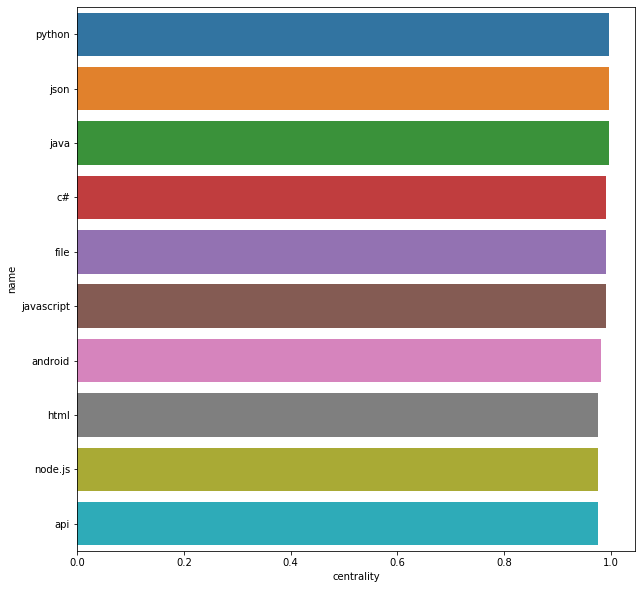

In [66]:
plt.figure(figsize=(10, 10))
_ = sns.barplot(x="centrality", y="name", data=cls_cent_df, orient='h')
plt.show()

In [67]:
# get similar tags by using weights

def get_similar_tags(tag, n=5):
    global tags_graph
    if not tags_graph.has_node(tag):
        return []
    sorted_neighbors = sorted(tags_graph[tag].items(), key=lambda edge: edge[1]["weight"], reverse=True)
    return [tag[0] for tag in sorted_neighbors[1:n+1]]
    
get_similar_tags("python")

['pandas', 'django', 'numpy', 'dataframe', 'tensorflow']

In [68]:
get_similar_tags("rx-swift")

['ios', 'rx-cocoa', 'mvvm', 'reactive-programming', 'observable']

### Users help network (asking - answering) in degree

<img src="SNASO/users_to_users_in_degree.png" style="height:500px" />

### Users help network (asking - answering) out degree

<img src="SNASO/users_to_users_out_degree.png" style="height:500px" />

In [69]:
print(nx.info(G_users))

Name: 
Type: DiGraph
Number of nodes: 647714
Number of edges: 1495623
Average in degree:   2.3091
Average out degree:   2.3091


In [70]:
print("Density of graph:", nx.density(G_users))

Density of graph: 3.5649729368885505e-06


In [71]:
print("Clustering coefficent:", nx.average_clustering(G_users))

Clustering coefficent: 0.0035274747462812517


In [72]:
# Most questioners

sorted(G_users.in_degree, key=lambda x: x[1], reverse=True)[:5]

[(8291684, 355), (1422604, 295), (3044737, 250), (577805, 245), (1103606, 237)]

In [73]:
# Most answerers

sorted(G_users.out_degree, key=lambda x: x[1], reverse=True)[:6]

[(1144035, 7957),
 (0, 6335),
 (2901002, 3073),
 (1863229, 2921),
 (3732271, 2830),
 (10498828, 2385)]

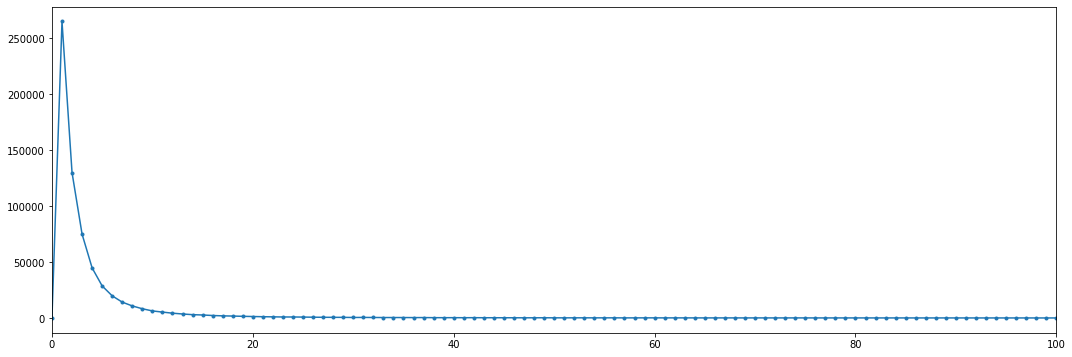

In [74]:
hist = nx.degree_histogram(G_users)
plt.figure(figsize=(18, 6))
plt.plot(hist, marker='.')
plt.xlim((0, 100))
plt.show()

In [75]:
degrees = G_users.degree() 
deg_values = [val[1] for val in degrees]
degrees_h = Counter(deg_values)
degrees_dict = collections.OrderedDict(sorted(degrees_h.items()))
degrees_hist = list(degrees_dict.values())
degrees_values = list(degrees_dict.keys())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  app.launch_new_instance()


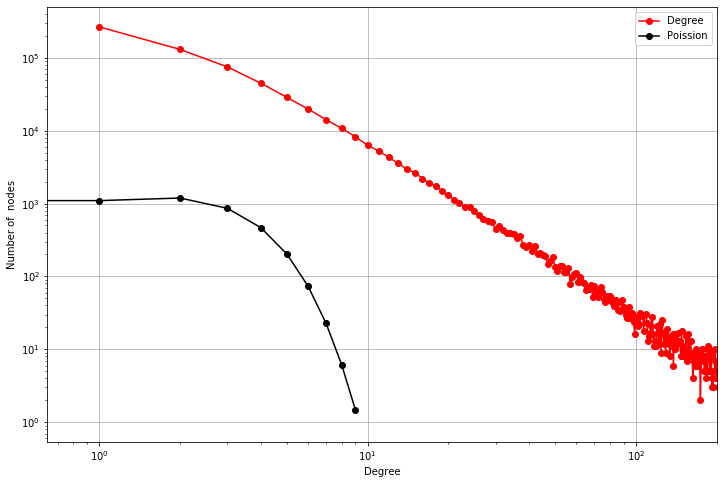

In [76]:
# plot degree distribution in log-log

mu = 2.17
sigma = sp.sqrt(mu)
mu_plus_sigma = mu + sigma
x = range(0, 10)
prob = stats.poisson.pmf(x, mu) * 4426

plt.figure(figsize=(12, 8)) 
plt.grid(True)
plt.loglog(degrees_values, degrees_hist, 'ro-')
plt.plot(x, prob, "o-", color="black")
plt.legend(['Degree','Poission'])
plt.xlabel('Degree')
plt.ylabel('Number of  nodes')
plt.xlim([0, 2 * 10 ** 2])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


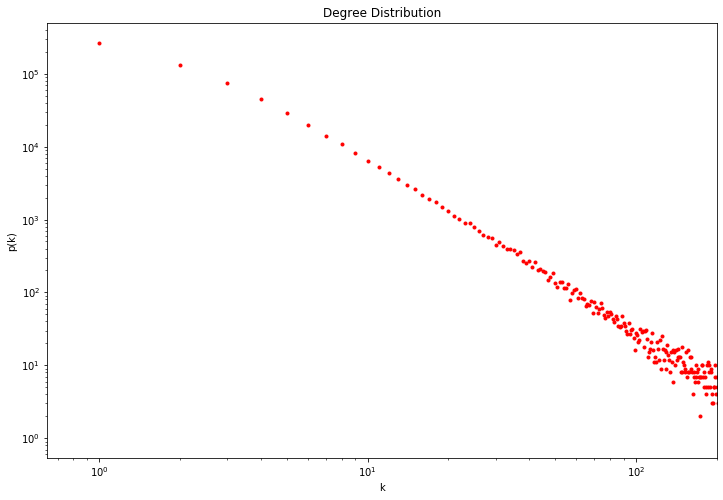

In [77]:
degrees =dict(G_users.degree())
values = sorted(set(degrees.values()))
hist = [list(degrees.values()).count(x) for x in values]

plt.figure(figsize=(12, 8)) 
plt.loglog(values, hist, 'r.') 
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Degree Distribution')
plt.xlim([0, 2*100**1])
plt.show()

In [78]:
# Filter the graph for next operations

users_node_degs = nx.degree(G_users)
filtered_users_graph = nx.subgraph(G_users, [x for x in G_users.nodes() if users_node_degs[x] > 150])
print(nx.info(filtered_users_graph))

Name: 
Type: DiGraph
Number of nodes: 1079
Number of edges: 3511
Average in degree:   3.2539
Average out degree:   3.2539


In [79]:
# for next operations, change graph to undirected and get largest component

filtered_users_graph_und = filtered_users_graph.to_undirected()
users_graph_components = nx.connected_components(filtered_users_graph_und)
users_graph_components = list(users_graph_components)
len(users_graph_components)

118

In [80]:
G_users_und = G_users.to_undirected()
users_graph_largest_component = G_users_und.subgraph(users_graph_components[0])

In [81]:
print("diameter:", nx.diameter(users_graph_largest_component))

diameter: 9


In [82]:
print("shortest path length:", nx.average_shortest_path_length(users_graph_largest_component))

shortest path length: 3.8085544120923935


In [83]:
print("node connectivity:", nx.node_connectivity(users_graph_largest_component))

node connectivity: 1


In [ ]:
print("self loops:", G_users.number_of_selfloops())

In [85]:
# degree centrality

nodes_deg_cen = nx.degree_centrality(G_users)
nodes_deg_cen_sorted = dict(sorted(nodes_deg_cen.items(), key=lambda item: item[1], reverse=True))

In [86]:
deg_cent_df = pd.DataFrame()    
deg_cent_df['name'] = [val[0] for val in list(nodes_deg_cen_sorted.items())[:11]]
deg_cent_df['centrality'] = [val[1] for val in list(nodes_deg_cen_sorted.items())[:11]]
deg_cent_df = deg_cent_df.drop(deg_cent_df.index[1])
deg_cent_df

,name,centrality
0,1144035,0.012285
2,2901002,0.004768
3,1863229,0.004522
4,3732271,0.004369
5,10498828,0.003682
6,1491895,0.003491
7,10676716,0.003421
8,3962914,0.003247
9,1447675,0.003185
10,7964527,0.003068


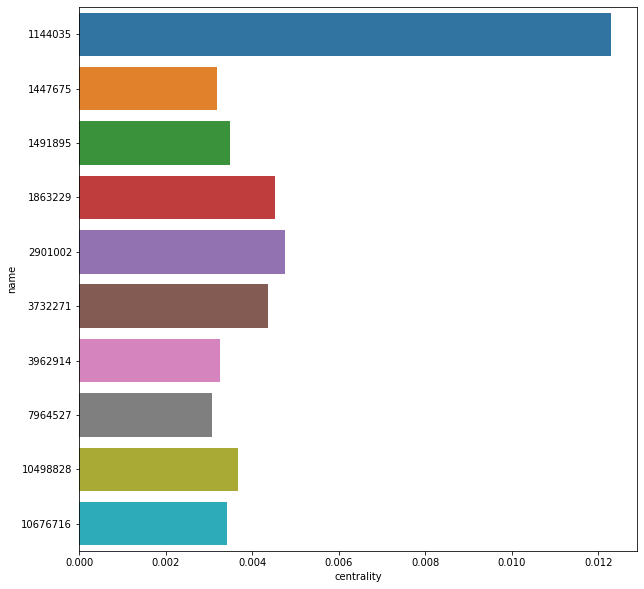

In [87]:
plt.figure(figsize=(10, 10))
_ = sns.barplot(x="centrality", y="name", data=deg_cent_df, orient='h')
plt.show()

In [88]:
def get_so_user(user_id):
    base_url = "https://api.stackexchange.com/2.2"
    get_user_end = base_url + "/users/{}?order=desc&sort=reputation&site=stackoverflow".format(user_id)
    try:
        response = requests.get(get_user_end)
    except requests.exceptions.ConnectionError as e:
        return 0, e
    return response.json()["items"][0]

In [89]:
user_info = get_so_user(1144035)

In [90]:
print("1144035 ->", user_info["display_name"], "reputation:", user_info["reputation"])

1144035 -> Gordon Linoff reputation: 1054862


### Users - tags network out degree

<img src="SNASO/users_to_tags_in_degree.png" style="height:500px" />

### Users - tags network in degree

<img src="SNASO/users_to_tags_out_degree.png" style="height:500px" />

In [91]:
print(nx.info(G_users_tags))

Name: 
Type: Graph
Number of nodes: 116038
Number of edges: 357862
Average degree:   6.1680


In [92]:
print("Density of graph:", nx.density(G_users_tags))

Density of graph: 5.315557905213305e-05


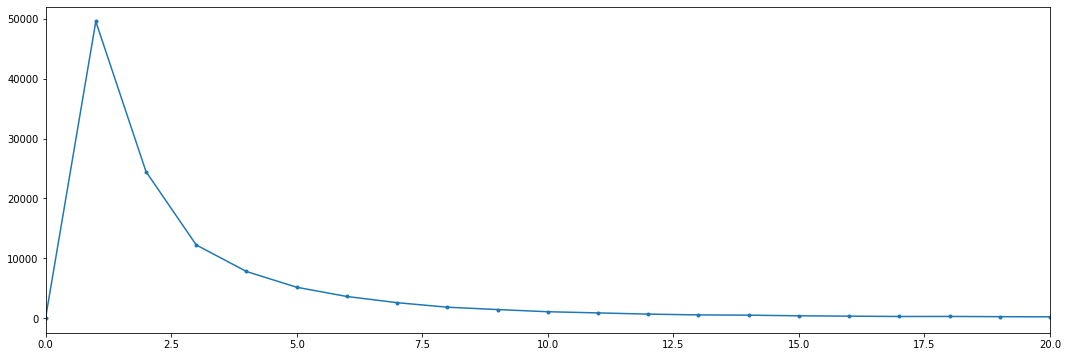

In [93]:
# plot degree distribution

hist = nx.degree_histogram(G_users_tags)
plt.figure(figsize=(18, 6))
plt.plot(hist, marker='.')
plt.xlim((0, 20))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


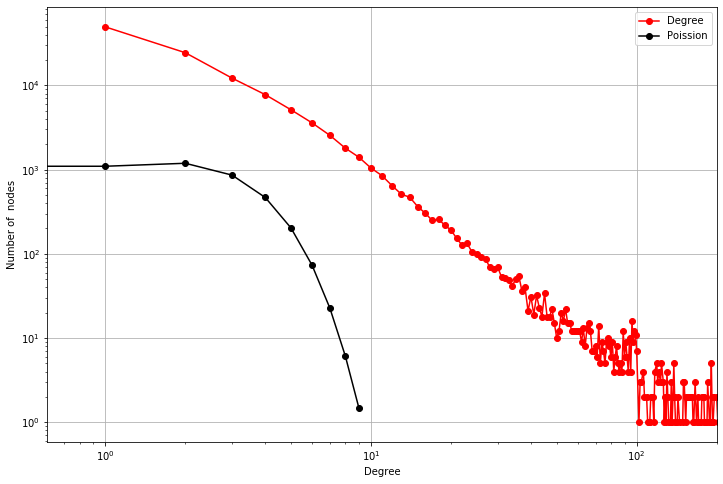

In [94]:
degrees = G_users_tags.degree() 
deg_values = [val[1] for val in degrees]
degrees_h = Counter(deg_values)
degrees_dict = collections.OrderedDict(sorted(degrees_h.items()))
degrees_hist = list(degrees_dict.values())
degrees_values = list(degrees_dict.keys())

# plot degree distribution in log-log

mu = 2.17
sigma = sp.sqrt(mu)
mu_plus_sigma = mu + sigma
x = range(0, 10)
prob = stats.poisson.pmf(x, mu) * 4426

plt.figure(figsize=(12, 8)) 
plt.grid(True)
plt.loglog(degrees_values, degrees_hist, 'ro-')
plt.plot(x, prob, "o-", color="black")
plt.legend(['Degree','Poission'])
plt.xlabel('Degree')
plt.ylabel('Number of  nodes')
plt.xlim([0, 2 * 10 ** 2])
plt.show()

In [95]:
# Filter the graph for next operations

user_tags_node_degs = nx.degree(G_users_tags)
filtered_user_tags_graph = nx.subgraph(G_users_tags, [x for x in G_users_tags.nodes() if user_tags_node_degs[x] > 150])
print(nx.info(filtered_users_graph))

Name: 
Type: DiGraph
Number of nodes: 1079
Number of edges: 3511
Average in degree:   3.2539
Average out degree:   3.2539


In [ ]:
# in degree centrality (tags)

nodes_deg_cen_in = nx.in_degree_centrality(G_users_tags)
nodes_deg_cen_in_sorted = dict(sorted(nodes_deg_cen_in.items(), key=lambda item: item[1], reverse=True))
nodes_deg_cen_in_sorted

In [ ]:
deg_cent_df = pd.DataFrame()    
deg_cent_df['name'] = [val[0] for val in list(nodes_deg_cen_in_sorted.items())[:11]]
deg_cent_df['centrality'] = [val[1] for val in list(nodes_deg_cen_in_sorted.items())[:11]]
deg_cent_df = deg_cent_df.drop(deg_cent_df.index[1])
deg_cent_df

In [ ]:
plt.figure(figsize=(10, 10))
_ = sns.barplot(x="centrality", y="name", data=deg_cent_df, orient='h')
plt.show()

In [97]:
users = [x for x, y in G_users_tags.nodes(data=True) if y["type"]=="user"]
users

[2557682,
 1175327,
 506147,
 5676949,
 10946509,
 2233668,
 11941541,
 10537235,
 11217383,
 336920,
 10808802,
 3107858,
 4718734,
 5404647,
 11208147,
 4480248,
 240363,
 303914,
 12274,
 7984318,
 26685,
 2753629,
 12136050,
 2916405,
 8061973,
 651174,
 6661426,
 1208144,
 1241715,
 1895264,
 8339821,
 2534758,
 10798194,
 1593077,
 5769463,
 1123717,
 12063339,
 4762063,
 365462,
 5268667,
 1318266,
 4386626,
 10749925,
 3067524,
 12521170,
 12191192,
 505854,
 1011722,
 2561452,
 4266314,
 12232041,
 709537,
 6500085,
 9115678,
 9578604,
 1340075,
 11554051,
 1202808,
 7500995,
 9959152,
 1922589,
 206466,
 2825403,
 11482834,
 5752410,
 4187091,
 3750856,
 4979468,
 6723250,
 10530848,
 470184,
 684229,
 2847689,
 157525,
 11622712,
 11156090,
 11456863,
 2446374,
 12628001,
 1897423,
 2777850,
 5077196,
 5014221,
 10244126,
 6676139,
 9525876,
 9881679,
 1252748,
 6388753,
 1281501,
 2102748,
 1136506,
 1304247,
 4955663,
 4396701,
 2091534,
 344286,
 6039995,
 7551257,
 73555

In [98]:
tags = [x for x, y in G_users_tags.nodes(data=True) if y["type"]=="tag"]
tags

['asp.net-core',
 'c#',
 'php',
 'angularjs',
 'javascript',
 'regex',
 'asp.net',
 'sql-server',
 '.net',
 'visual-studio',
 'sql-server-2012',
 'asp.net-mvc',
 'html',
 'entity-framework',
 'entity-framework-core',
 'bootstrap-4',
 'css',
 'reactjs',
 'ruby-on-rails',
 'java',
 'django',
 'python',
 'android',
 'ruby',
 'ruby-on-rails-3',
 'rspec',
 'heroku',
 'ruby-on-rails-4',
 'sinatra',
 'capybara',
 'activerecord',
 'postgresql',
 'tdd',
 'arrays',
 'git',
 'api',
 'mongodb',
 'mongoid',
 'unit-testing',
 'testing',
 'hash',
 'rubygems',
 'gem',
 'bdd',
 'jquery',
 'sql',
 'flutter',
 'dart',
 'numpy',
 'c++',
 'r',
 'grafana',
 'node.js',
 'cordova',
 'mysql',
 'graphql',
 'ajax',
 'sass',
 'gulp',
 'webpack',
 'facebook',
 'angular',
 'c',
 'typescript',
 'perl',
 'unix',
 'haskell',
 'bash',
 'shell',
 'django-views',
 'django-templates',
 'django-models',
 'selenium',
 'python-3.x',
 'pandas',
 'python-2.7',
 'google-apps-script',
 'oracle',
 'plsql',
 'vim',
 'linux',
 'xml

In [99]:
def adamic_adar_similarity(node, n=5, get_weights=False):
    global G_users_tags
    common_users_dict = {}
    
    for x in G_users_tags.neighbors(node):
        for y in G_users_tags.neighbors(x):
            if y == node:
                continue
            if G_users_tags.nodes[y]["type"] == G_users_tags.nodes[node]["type"]:
                commons = common_users_dict.get(y)
                if commons==None:
                    common_users_dict.update({y : [x]})
                else:
                    commons.append(x)
                    common_users_dict.update({y : commons})
                    
    users = []
    weights = []
                    
    for key, values in common_users_dict.items():
        w = 0.0
        for e in values:
            w = w + 1 / math.log(G_users_tags.degree(e))
        users.append(key) 
        weights.append(w)
        
    if get_weights:
        return list(zip(users, weights))[:n]
    
    return users[:n]

adamic_adar_similarity(2557682)

[506147, 5077196, 10021083, 1303170, 825920]

In [100]:
adamic_adar_similarity("networkx", get_weights=True)

[('python', 10.706228261232313),
 ('python-3.x', 4.9032091903595525),
 ('list', 3.612269845988118),
 ('dictionary', 2.6970770171218783),
 ('pulp', 0.45511961331341866)]